hola MUNDO

1. Lectura de los archivos en PDF

In [75]:
from pdfminer.high_level import extract_text
import os
import re

def load_PDF(files):
    papers = dict()

    # Pattern for simple prerpocessing
    pattern = r'[^a-zA-Z-_*.\s]|\n'

    for paper in files:
        doc = extract_text("Docs_para_classif\\" + str(paper))
        pre_doc = re.sub(pattern, '', doc)
        papers.update({str(paper): pre_doc})

    return papers

Lectura de los PDF ubicados en la caropeta *Docs_para_classif*

In [76]:
files = os.listdir('Docs_para_classif')

papers = load_PDF(files)
papers

{'EEG01.pdf': 'Journal of Neuroscience Methods   Contents lists available at ScienceDirectJournal of Neuroscience Methodsjournal homepage www.elsevier.comlocatejneumethInvited reviewClinical implication of high-density EEG sleep recordings in ParkinsonsdiseaseTNinfa Amatoa Serena Caverzasioab Salvatore Galatiab*a Parkinsons Disease and Movement Disorders Center Neurocenter of Southern Switzerland - Institute of Clinical Neuroscience of Southern Switzerland LuganoSwitzerlandb Faculty of Biomedical Sciences University of Southern Switzerland Lugano SwitzerlandA R T I C L E I N F OA B S T R A C TKeywordsParkinsons diseaselevodopa-induced dyskinesianon-motor symptomssleep disordersprognostic toolspolysomnographyThe diagnosis of Parkinsons disease PD is made relatively late in the pathological process when already mostof the dopaminergic synapses have died. The evidence showed that at the time of the clinical diagnosis whichcan be done only after motor symptoms appearance the pathogenetic p

2. Prepocesamiento

In [77]:
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem.porter import PorterStemmer
import pprint


def preprocess_text(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # Tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stopW = stopwords.words('english')
    en_stopW.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '-', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'www', '...', 'fig',
                    'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'et', 'al'])
    en_stopW = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()

    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)  # op1
        tok = word_tokenize(raw)  # op2
        # remove stop words from tokens
        stopped_tokens = [i for i in tok if not i in en_stopW]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # Save the words with more one letter
        process_doc = [
            stemmed_tokens for stemmed_tokens in stemmed_tokens if len(stemmed_tokens) > 2]
        # add tokens to list
        texts.append(process_doc)

    return texts

In [78]:
preprocess = preprocess_text(papers.values())

3. Creación del corpus

In [79]:
from gensim import corpora


def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    corpus = [dictionary.doc2bow(doc) for doc in doc_clean]

    return dictionary, corpus

Crear modelos

In [80]:
from gensim.models import LdaModel, LsiModel, RpModel
import warnings
warnings.filterwarnings('ignore')

def LDA_model(dictionary, corpus , number_of_topics, words=10, show=False):
    """_summary_

    Args:
        doc_clean (_type_): _description_
        number_of_topics (_type_): _description_
        words (int): The number of requested latent topics to be extracted from the training corpus.

    Returns:
        _type_: _description_
    """
    # LDA model
    ldamodel = LdaModel(corpus, num_topics=number_of_topics, id2word=dictionary)  # train model
    if show:
        print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))

    return ldamodel


def LSI_model(dictionary, corpus , number_of_topics, words=50, show=False):
    """_summary_

    Args:
        doc_clean (_type_): _description_
        number_of_topics (_type_): _description_
        words (_type_): _description_

    Returns:
        _type_: _description_
    """
    # LSI model
    lsimodel = LsiModel(corpus, num_topics=number_of_topics,
                        id2word=dictionary)  # train model
    if show:
        print(lsimodel.print_topics(num_topics=number_of_topics, num_words=words))

    return lsimodel

In [81]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(doc_clean, function, stop, start=2, step=3, words=50):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """    
    dictionary, corpus = prepare_corpus(doc_clean)
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        if function == 'LDA':
            model = LDA_model(dictionary, corpus , number_of_topics=num_topics, words=words)
        elif function == 'LSI':
            model = LSI_model(dictionary, corpus , number_of_topics=num_topics, words=words)     
        else:
            raise Exception('The model selected is not defined')
                       
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_uci')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graph(doc_clean, function, start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(doc_clean, function, stop, start, step)  
    # Define figure
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.title('Coherence with model ' + function)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

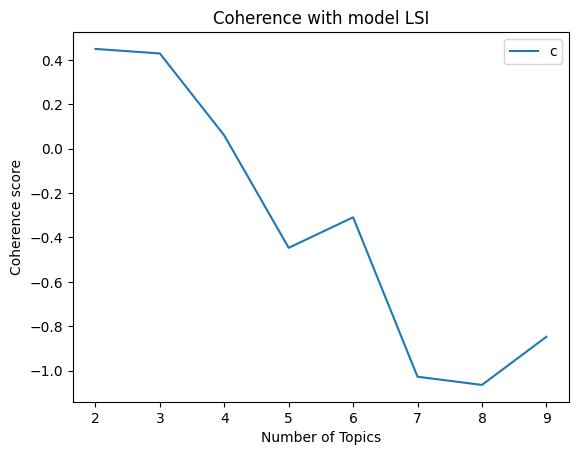

In [83]:
start, stop, step = 2, 10, 1
plot_graph(preprocess, 'LSI', start, stop, step)

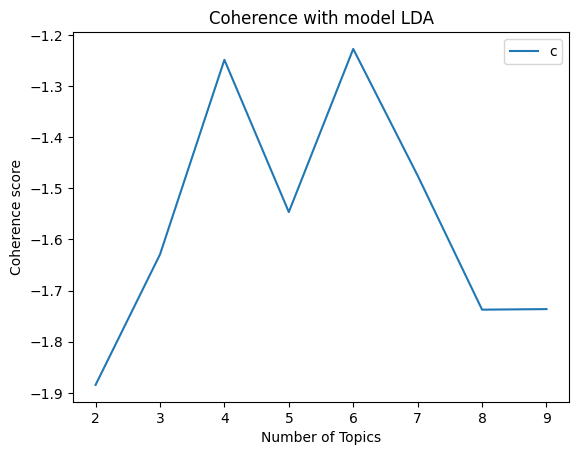

In [84]:
plot_graph(preprocess, 'LDA', start, stop, step)

In [85]:
import pyLDAvis.gensim_models as gensimvis
import pickle
import gensim
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

num_topics = 3
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# Build LDA model
dictionary, corpus = prepare_corpus(preprocess)
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
doc_lda = lda_model[corpus]

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(
    LDAvis_prepared, './results/ldavis_prepared_' + str(20) + '.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.012278 -0.000855       1        1  45.927344
1      0.008928 -0.002394       2        1  27.814067
0      0.003350  0.003249       3        1  26.258589, topic_info=         Term        Freq       Total Category  logprob  loglift
1644     test  289.000000  289.000000  Default  30.0000  30.0000
274      case  217.000000  217.000000  Default  29.0000  29.0000
1635     task  219.000000  219.000000  Default  28.0000  28.0000
1017    model  315.000000  315.000000  Default  27.0000  27.0000
3799   depend   82.000000   82.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
5571    fusel   51.608128  261.862550   Topic3  -5.8615  -0.2870
570   extract   39.056692  154.259812   Topic3  -6.1401  -0.0364
748    improv   43.656621  209.239559   Topic3  -6.0288  -0.2299
1394   result   38.930484  170.445215   Topic3  -6.1434  -0.1395
325    compar   37.671128  148.909326   Topic3  -6.1762  -0.0373

[270 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
3          1  0.532512        ...
3          2  0.266256        ...
3          3  0.199692        ...
4          1  0.626011       ....
4          2  0.175722       ....
...      ...       ...        ...
6745       2  0.126756     yilmaz
6745       3  0.253511     yilmaz
11484      1  0.303075  zero-shot
11484      2  0.454613  zero-shot
11484      3  0.151538  zero-shot

[569 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [86]:
import numpy as np 
import pandas as pd

dictionary, corpus = prepare_corpus(preprocess)
ldamodel = LDA_model(dictionary, corpus, number_of_topics=3)

In [87]:
all_topics = ldamodel.get_document_topics(corpus)
all_topics
num_docs = len(all_topics)

all_topics_csr= gensim.matutils.corpus2csc(all_topics)
all_topics_numpy= all_topics_csr.T.toarray()

# A qué topico grupo pertenece? 
major_topic= [np.argmax(arr) for arr in all_topics_numpy]

In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=2017, perplexity=3)
embedding = tsne.fit_transform(all_topics_numpy)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['topic'] = major_topic

Agrupamiento

<Axes: xlabel='x', ylabel='y'>

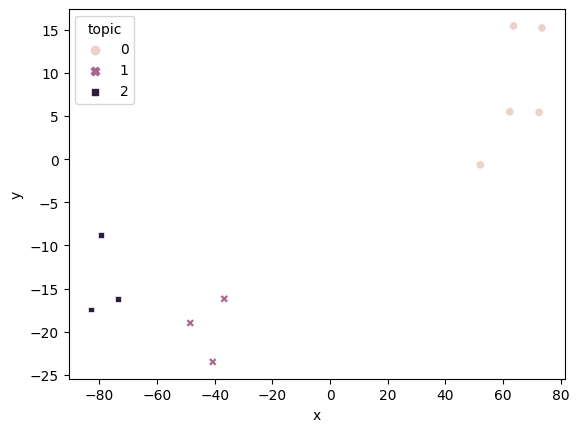

In [89]:
import seaborn as sns
sns.scatterplot(data=embedding, x="x", y="y", hue="topic", style="topic")

In [90]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

Centroides de los clusters: 
 [[0.98710637 0.         0.01167864]
 [0.07477706 0.80436069 0.12084102]
 [0.04012732 0.04814294 0.91105741]]
Grupos:  [0 0 2 1 1 1 2 2 0 0 0]
Precisión:  -0.20876440234388885


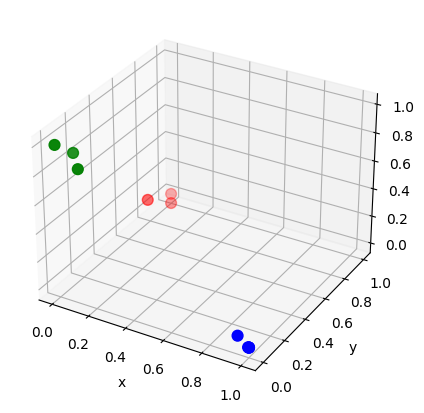

In [91]:
# define dataset
X = all_topics_numpy
# define the model
model = KMeans(n_clusters=3).fit(X)
centroids = model.cluster_centers_
print('Centroides de los clusters: \n', centroids)
print('Grupos: ', model.labels_)
print('Precisión: ', model.score(all_topics_numpy))

# assign a cluster to each example
predicts = model.predict(X)
# create scatter plot for samples
colores = ['blue', 'red', 'green', 'blue', 'cyan', 'yellow', 'orange', 'black', 'pink', 'brown', 'purple']
asignar = []
for row in predicts:
    asignar.append(colores[row])

# Gráfica
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
#  ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar, s=60)
Dim_plot = ['x', 'y', 'z']
ax.set_xlabel(Dim_plot[0])
ax.set_ylabel(Dim_plot[1])
ax.set_zlabel(Dim_plot[2])
plt.show()